See how well you can approximate the cooling effect to 

- Annual mean VPD
- Annual Tmax

In [1]:
from pathlib import Path
import os

# Define output and input directories (make clean directories for UNU)
INPUT_DIR = Path("/Users/viggo/Documents/Programming/Consult/UNU/data")
OUTPUT_DIR = Path("/Users/viggo/Documents/Programming/Consult/UNU/output")

import sys
import os

# Get the current working directory (where the notebook is)
notebook_dir = os.getcwd()

# Add the parent directory to the Python path
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
# Print the updated Python path for debugging
print("Updated Python path:", sys.path)

Updated Python path: ['/Users/viggo/miniforge3/envs/climada_env/lib/python311.zip', '/Users/viggo/miniforge3/envs/climada_env/lib/python3.11', '/Users/viggo/miniforge3/envs/climada_env/lib/python3.11/lib-dynload', '', '/Users/viggo/miniforge3/envs/climada_env/lib/python3.11/site-packages', '__editable__.climada-6.0.2.dev0.finder.__path_hook__', '/Users/viggo/Documents/Programming/Consult/UNU/coffee_banana_cacao_climate_risk']


Load tha annual VPD

In [2]:
from cb_agroforesty.utils_cb import load_isimip_multi_and_subset, COUNTRY_BOUNDS

# Load ISIMIP data for tas and hurs
tas_files = sorted(INPUT_DIR.glob("Isimip/20crv3-era5_obsclim_tas_global_daily_*.nc"))
hurs_files = sorted(INPUT_DIR.glob("Isimip/20crv3-era5_obsclim_hurs_global_daily_*.nc"))

# Define bounding box for the region of interest
tas_gs, hurs_gs = load_isimip_multi_and_subset(tas_files, 
                                               hurs_files,
                                                bbox=COUNTRY_BOUNDS['MEX'])  # Bounding box for Mexico

In [3]:
import numpy as np
import xarray as xr

def compute_annual_vpd_with_cooling(tas_gs, hurs_gs, temp_reduction=0.0):
    """
    Compute annual mean VPD per grid point, with optional cooling (applied uniformly across all days and locations).

    Parameters:
    - tas_gs: xarray DataArray of daily temperature (tas), with 'time', 'lat', 'lon' dims
    - hurs_gs: xarray DataArray of daily relative humidity (hurs), same dims as tas_gs
    - temp_reduction: float, degrees Celsius to subtract from temperature (e.g., -2.0 for 2°C cooling)

    Returns:
    - vpd_annual: xarray.DataArray of annual mean VPD [year x lat x lon]
    """

    # Apply cooling to temperature
    tas_adjusted = tas_gs + temp_reduction

    # Saturation vapor pressure (es) in kPa
    es = 0.6108 * np.exp((17.27 * tas_adjusted) / (tas_adjusted + 237.3))

    # Actual vapor pressure (ea)
    ea = (hurs_gs / 100.0) * es

    # VPD = es - ea
    vpd = es - ea

    # Group by year and average
    vpd_annual = vpd.groupby("time.year").mean("time")  # shape: [year x lat x lon]

    return vpd_annual



In [4]:
# Without cooling
vpd_baseline = compute_annual_vpd_with_cooling(tas_gs, hurs_gs, temp_reduction=0.0)

# With -2°C cooling applied to all days
vpd_cooled = compute_annual_vpd_with_cooling(tas_gs, hurs_gs, temp_reduction=-2.0)

# Difference
vpd_delta = vpd_cooled - vpd_baseline


In [5]:
def adjust_annual_vpd_with_cooling(vpd_annual, cooling_deg, sensitivity=0.15):
    """
    Adjust annual mean VPD using a linear approximation for temperature sensitivity.

    Parameters:
    - vpd_annual: xarray.DataArray of baseline VPD [year x lat x lon] or [year x site]
    - cooling_deg: float, degrees of cooling (e.g. -2.0 means reduce temperature by 2°C)
    - sensitivity: float, VPD change per °C (default 0.15 kPa/°C)

    Returns:
    - vpd_adjusted: xarray.DataArray of adjusted annual VPD
    """
    delta_vpd = cooling_deg * sensitivity
    return vpd_annual + delta_vpd


In [6]:
# Apply 1.5°C cooling
vpd_approx = adjust_annual_vpd_with_cooling(vpd_baseline, cooling_deg=-1.5)

# Compare against physically derived value
vpd_physical = compute_annual_vpd_with_cooling(tas_gs, hurs_gs, temp_reduction=-1.5)

# Difference due to approximation
diff = vpd_physical - vpd_approx


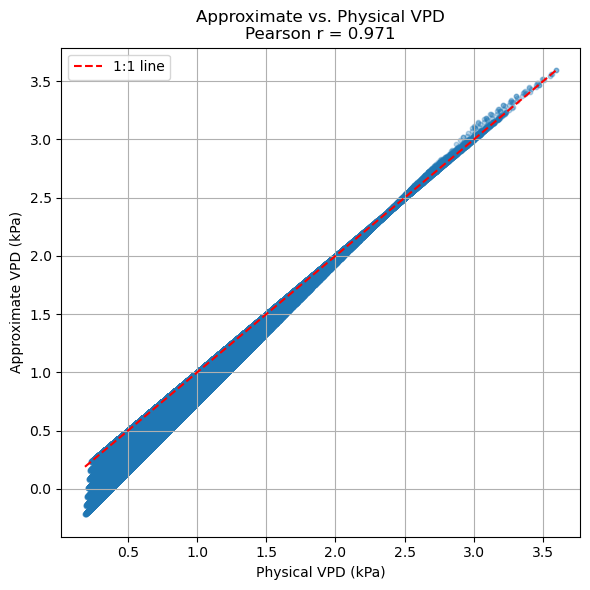

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.stats import pearsonr

# Cooling levels to test (in °C)
cooling_values = np.arange(0, -3.1, -0.5)  # 0 to -3°C

# Store flattened VPD values for each cooling level
approx_all = []
physical_all = []

for cooling in cooling_values:
    # Approximate method
    vpd_approx = adjust_annual_vpd_with_cooling(vpd_baseline, cooling_deg=cooling)
    
    # Physical method
    vpd_physical = compute_annual_vpd_with_cooling(tas_gs, hurs_gs, temp_reduction=cooling)
    
    # Flatten both to 1D arrays (exclude NaNs)
    vpd_approx_flat = vpd_approx.values.flatten()
    vpd_physical_flat = vpd_physical.values.flatten()
    
    valid = ~np.isnan(vpd_approx_flat) & ~np.isnan(vpd_physical_flat)
    
    approx_all.extend(vpd_approx_flat[valid])
    physical_all.extend(vpd_physical_flat[valid])

# Convert to numpy arrays
approx_all = np.array(approx_all)
physical_all = np.array(physical_all)

# Compute correlation
r, p_value = pearsonr(approx_all, physical_all)

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(physical_all, approx_all, alpha=0.3, s=10)
plt.plot([physical_all.min(), physical_all.max()],
         [physical_all.min(), physical_all.max()],
         'r--', label='1:1 line')

plt.xlabel("Physical VPD (kPa)")
plt.ylabel("Approximate VPD (kPa)")
plt.title(f"Approximate vs. Physical VPD\nPearson r = {r:.3f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
def estimate_vpd_reduction(cooling, sensitivity=0.15):
    """
    Convert cooling (°C) to approximate annual mean VPD reduction (kPa).

    Parameters:
    - cooling: scalar or array, temperature reduction in °C (negative values expected)
    - sensitivity: VPD change per °C, default 0.15 kPa/°C

    Returns:
    - vpd_reduction: estimated annual mean VPD change in kPa (also negative)
    """
    return sensitivity * cooling


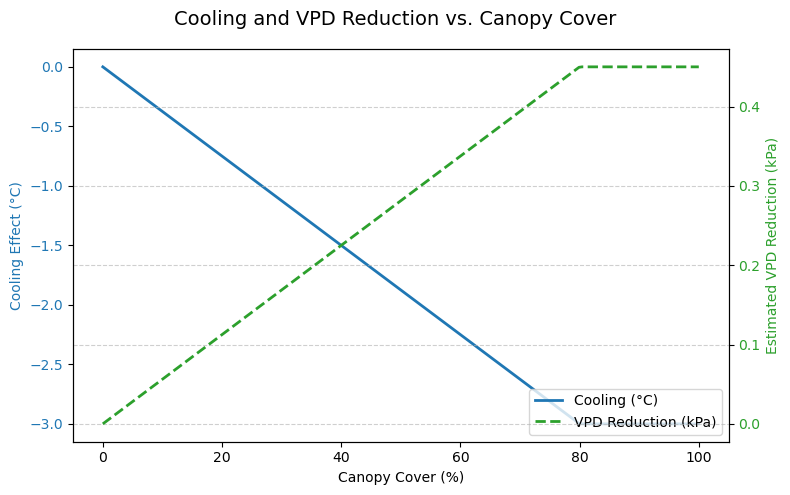

In [9]:
from cb_agroforesty.utils_cb import canopy_cooling

import matplotlib.pyplot as plt
import numpy as np


# Inputs
canopy = np.linspace(0, 100, 200)
cooling = canopy_cooling(canopy, max_cooling=3, plateau_at=80)
vpd_reduction = 0.15 * cooling  # estimated ΔVPD using linear sensitivity

# Plot
fig, ax1 = plt.subplots(figsize=(8, 5))

# Primary Y-axis: Cooling effect
color1 = 'tab:blue'
ax1.plot(canopy, cooling, color=color1, label='Cooling (°C)', linewidth=2)
ax1.set_xlabel('Canopy Cover (%)')
ax1.set_ylabel('Cooling Effect (°C)', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

# Secondary Y-axis: VPD reduction
ax2 = ax1.twinx()
color2 = 'tab:green'
ax2.plot(canopy, -vpd_reduction, color=color2, linestyle='--', label='VPD Reduction (kPa)', linewidth=2)
ax2.set_ylabel('Estimated VPD Reduction (kPa)', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Titles and legend
fig.suptitle('Cooling and VPD Reduction vs. Canopy Cover', fontsize=14)
fig.tight_layout()
plt.grid(True, linestyle='--', alpha=0.6)

# Optional: Combined legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='lower right')

plt.show()



In [10]:
# 1. Daily temperature and RH are already loaded:
# tas_gs: xarray.DataArray of daily temperature [time, lat, lon]
# hurs_gs: xarray.DataArray of daily RH [%] [time, lat, lon]

# 2. Compute long-term mean temperature and RH
tas_mean = tas_gs.mean(dim="time")     # Result: [lat, lon]
rh_mean = hurs_gs.mean(dim="time")     # Result: [lat, lon]

def compute_vpd_sensitivity(tas_mean, rh_mean):
    """
    Estimate VPD sensitivity to temperature per site based on tas and RH.
    Returns: xarray.DataArray [lat x lon]
    """
    es = 0.6108 * np.exp((17.27 * tas_mean) / (tas_mean + 237.3))
    d_es_d_t = es * 17.27 * 237.3 / (tas_mean + 237.3)**2
    sensitivity = d_es_d_t * (1 - rh_mean / 100)
    return sensitivity

def adjust_annual_vpd_with_site_sensitivity(vpd_annual, cooling_deg, sensitivity_map):
    """
    Adjust VPD using a site-specific sensitivity map and uniform cooling value.
    """
    delta_vpd = cooling_deg * sensitivity_map
    return vpd_annual + delta_vpd

sensitivity_map = compute_vpd_sensitivity(tas_mean, rh_mean)
# Apply site-specific sensitivity to the baseline VPD
vpd_adjusted = adjust_annual_vpd_with_site_sensitivity(vpd_baseline, cooling_deg=-1.5, sensitivity_map=sensitivity_map)


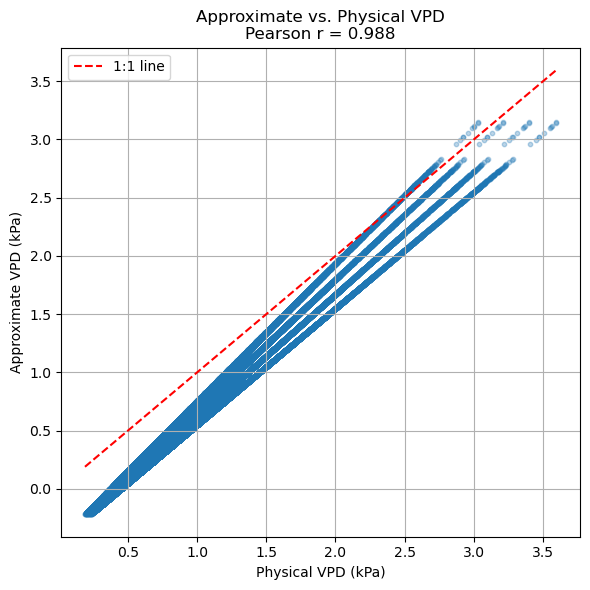

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.stats import pearsonr

# Cooling levels to test (in °C)
cooling_values = np.arange(0, -3.1, -1)  # 0 to -3°C

# Store flattened VPD values for each cooling level
approx_all = []
physical_all = []

for cooling in cooling_values:
    # Approximate method
    vpd_adjusted = adjust_annual_vpd_with_site_sensitivity(vpd_baseline, cooling_deg=cooling, sensitivity_map=sensitivity_map)
    
    # Physical method
    vpd_physical = compute_annual_vpd_with_cooling(tas_gs, hurs_gs, temp_reduction=cooling)
    
    # Flatten both to 1D arrays (exclude NaNs)
    vpd_approx_flat = vpd_approx.values.flatten()
    vpd_physical_flat = vpd_physical.values.flatten()
    
    valid = ~np.isnan(vpd_approx_flat) & ~np.isnan(vpd_physical_flat)
    
    approx_all.extend(vpd_approx_flat[valid])
    physical_all.extend(vpd_physical_flat[valid])

# Convert to numpy arrays
approx_all = np.array(approx_all)
physical_all = np.array(physical_all)

# Compute correlation
r, p_value = pearsonr(approx_all, physical_all)

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(physical_all, approx_all, alpha=0.3, s=10)
plt.plot([physical_all.min(), physical_all.max()],
         [physical_all.min(), physical_all.max()],
         'r--', label='1:1 line')

plt.xlabel("Physical VPD (kPa)")
plt.ylabel("Approximate VPD (kPa)")
plt.title(f"Approximate vs. Physical VPD\nPearson r = {r:.3f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Figure out a really fast way to adjust the annual VPD

In [12]:
import xarray as xr
import os

# ========================
# Settings
# ========================
output_dir = INPUT_DIR  / "terra_climate" 
os.makedirs(output_dir, exist_ok=True)

years = range(1985, 2023)
variables = ["tmin", "tmax", "ppt", "pet", "vpd"]
lat_bounds = (32, 13)
lon_bounds = (-120, -85)

# ========================
# Helper function
# ========================
def download_and_crop(var, year):
    url = f"http://thredds.northwestknowledge.net:8080/thredds/dodsC/TERRACLIMATE_ALL/data/TerraClimate_{var}_{year}.nc"
    print(f"🔄 Accessing {url}")
    try:
        ds = xr.open_dataset(url)
        ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))  # shift 0–360 to -180–180
        ds_crop = ds.sel(lat=slice(*lat_bounds), lon=slice(*lon_bounds))
        out_path = os.path.join(output_dir, f"TerraClimate_{var}_{year}_CA.nc")
        ds_crop.to_netcdf(out_path)
        print(f"✅ Saved to {out_path}")
    except Exception as e:
        print(f"❌ Failed for {var} {year}: {e}")

# ========================
# Run batch download
# ========================
for var in variables:
    for year in years:
        download_and_crop(var, year)


🔄 Accessing http://thredds.northwestknowledge.net:8080/thredds/dodsC/TERRACLIMATE_ALL/data/TerraClimate_tmin_1985.nc
✅ Saved to /Users/viggo/Documents/Programming/Consult/UNU/data/terra_climate/TerraClimate_tmin_1985_CA.nc
🔄 Accessing http://thredds.northwestknowledge.net:8080/thredds/dodsC/TERRACLIMATE_ALL/data/TerraClimate_tmin_1986.nc
✅ Saved to /Users/viggo/Documents/Programming/Consult/UNU/data/terra_climate/TerraClimate_tmin_1986_CA.nc
🔄 Accessing http://thredds.northwestknowledge.net:8080/thredds/dodsC/TERRACLIMATE_ALL/data/TerraClimate_tmin_1987.nc
✅ Saved to /Users/viggo/Documents/Programming/Consult/UNU/data/terra_climate/TerraClimate_tmin_1987_CA.nc
🔄 Accessing http://thredds.northwestknowledge.net:8080/thredds/dodsC/TERRACLIMATE_ALL/data/TerraClimate_tmin_1988.nc
✅ Saved to /Users/viggo/Documents/Programming/Consult/UNU/data/terra_climate/TerraClimate_tmin_1988_CA.nc
🔄 Accessing http://thredds.northwestknowledge.net:8080/thredds/dodsC/TERRACLIMATE_ALL/data/TerraClimate_tmin

In [13]:
# ========================
# Settings
# ========================
scenario = "plus2C"
prefix = "2c"
output_dir = "/Users/szelie/data/unu/terra_climate_scenarios_ncss"
os.makedirs(output_dir, exist_ok=True)


# ========================
# Helper function
# ========================
def download_and_crop(var, year):
    filename = f"TerraClimate_{prefix}_{var}_{year}.nc"
    url = f"http://thredds.northwestknowledge.net:8080/thredds/fileServer/TERRACLIMATE_ALL/data_{scenario}/{filename}"
    print(f"🔄 Accessing {url}")
    try:
        response = requests.get(url, timeout=60)
        response.raise_for_status()
        with open(filename, "wb") as f:
            f.write(response.content)
        ds = xr.open_dataset(filename)
        ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))
        ds_crop = ds[var].sel(lat=slice(*lat_bounds), lon=slice(*lon_bounds))
        out_path = os.path.join(output_dir, f"TerraClimate_{scenario}_{var}_{year}_CA.nc")
        ds_crop.to_netcdf(out_path)
        print(f"✅ Saved to {out_path}")
        os.remove(filename)
    except Exception as e:
        print(f"❌ Failed for {var} {year}: {e}")

# ========================
# Run batch download
# ========================
for var in variables:
    for year in years:
        download_and_crop(var, year)

PermissionError: [Errno 13] Permission denied: '/Users/szelie'